# Particle Swarm Optimization 
## Introduction
The problem:
In this assignment, we will be using the Particle Swarm algorithm to find the global minimum of a non-convex function. Particle Swarm Optimization is a biologically inspired algorithm that mimics a flock of birds or a school of fish. Similar to the Genetic Algorithm, PSO starts with a randomly created initial population, a set of possible solutions (called particles), and updates these particles after every iteration. However, GA uses crossover and mutation to create new individuals, whereas PSO maintains the same population but changes each particle over time. 

We have provided code stubs in this notebook to get you started, and give hints about the structure of the code.

You need to implement Particle Swarm Optimization, and analyze the results. 

## Approach: 
Let's start with a few definitions. 
- Particle (aka "individual"): a solution to the non-convex function $f(\overrightarrow{x})$, which we are trying to minimize. The particle's position in the swarm is defined to be this vector, which represents a possible solution to the problem. The particle also has a velocity vector, and variables that record the "best" (lowest) value found so far. 
- Population: a collection of possible solutions to the function (i.e., a collection of Particles)
- Fitness: a function that tells us how good each Particle is. For a given solution $\overrightarrow{x}$, to minimize/maximize the objective function, the lower/higher the value of the objective function after plugging in the solution (i.e. $f(\overrightarrow{x})$), the higher the fitness/value of the solution.

Our Particle Swarm will proceed in the following steps:
1. Create the population (initialized with random positions and velocities)
2. Initialize the global best value and all the Particles' individual best values. All best fitness initializations should be to $-\infty$
2. Update each Particle's individual best as well as the global best value found so far 
3. Update each Particle's velocity subject to the equation learned in class, and then update the Particle's position 
4. Update $w$
5. Repeat steps 3-4 for until the solution has converged 
6. Plot your results (best values)

### Algorithm:
At every iteration, the position of each Particle gets updated. Each Particle has a position vector, $x$, and a velocity vector, $v$. The velocity vector is changed, and then each element of the velocity vector gets added to each element of the position vector. The length of $x$ and $v$ is equal to dimension ($n$).

The velocity vector is updated in the following way: 

$v_i^{t+1}$ = inertia + cognitive velocity + social velocity 

- inertia = $w$ * $v_i^{t}$

- cognitive velocity = $c_1$ * $r_1$ * (personal best position - current position)

- social velocity = $c_2$ * $r_2$ * (global best position - current position)

And the position vector is then updated:

$x_i^{t+1}$ = $x_i^{t}$ + $v_i^{t+1}$

$r_1$ and $r_2$ are random numbers between 0 and 1, and $c_1$ and $c_2$ are the cognitive and social parameters, respectively.


The direction that the particle will move in each iteration depends on these three vectors (inertia, cognitive velocity, social velocity). Cognitive velocity pushes the Particle towards its personal best, and social (global) velocity pushes the Particle towards the global best. 

![picture](https://drive.google.com/uc?export=view&id=1O_fB3TsyyTsFDHVjBy99GIQ14tWSzL_n)


In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import operator
import math
import sys
from datetime import datetime
from util import plot_particles, record_to_pv

We will set global variable dimension as the number of variables in the function we are minimizing. 

$f(\overrightarrow{x}) = x_{1}^{2} + (x_{2}+1)^{2} - 5cos(1.5x_{1} + 1.5) - 5cos(2x_{2}-1.5)$

The function is written below. 

In [2]:
dim = 2
def func(x):
    x_ = x[0]
    y_ = x[1]
    return x_**2 + (y_+1)**2 - 5*np.cos(1.5*x_ + 1.5) - 5 * np.cos(2* y_ - 1.50)

## Create necessary classes and functions
Next, we create a class that will represent and handle an individual Particle in the population. A Particle only needs its position vector to be initialized. Velocity starts with random values, and we have variables that keep track of this Particle's best position so far and the value that this position yields. This means that this is the position, or solution, found by this Particle that gives the lowest value when plugged into the polynomial. 

Note that the goal is to minimize the value of the polynomial, therefore the fitness should be the **opposite** of the polynomial when we plug in this Particle's position (i.e. particle.fitness = -func(particle.position)). 

There are functions that are used to update the velocity and position of the Particle based on the equations above. When updating position, we must make sure each element of position stays within the desired bounds. This means that if the new position value is outside of the interval [$-100, 100$], we set the value to the boundary value. 

## 1.1 (5 points)
**TO-DO**

1. `update_velocity`
2. `update_position`

In [3]:
class Particle:
    def __init__(self, position):
        """
        position: the position of this Particle, a list of length 2
        velocity: the velocity of this Particle, a list of length 2
        best_position: the best position found so far by this Particle
        best_value: the best (lowest) value found so far by this Particle
        """
        self.position = position
        self.velocity = np.array([random.uniform(-2,2) for i in range(dim)])
        self.best_position = np.copy(position)
        self.best_fitness = -math.inf
    
    def fitness(self):
        """
        This fitness function is defined as the opposite value of this Particle
        when plugged into the function polynomial.
        """
        return -func(self.position)

    def update_velocity(self, w, c1, c2, best_position_global):
        """
        w, c1, c2: constants
        best_position_global: the best position found in the whole population so far 
        This function updates the Particle's velocity
        """
        #YOUR CODE HERE
        for i in range(0, 2):
            inertia = self.velocity[i] * w
            cog = c1 * np.random.uniform(0,1) * (self.best_position[i] - self.position[i])
            soc = c2 * np.random.uniform(0,1) * (best_position_global[i] - self.position[i])
            self.velocity[i] = inertia + cog + soc
        return self.velocity

    def update_position(self):
        """
        Updates the Particle's position
        """
        #YOUR CODE HERE
        for i in range(0, 2):
            self.position[i] = self.position[i] + self.velocity[i]
            
            if self.position[i] > 100:
                self.position[i] = 100
            elif self.position[i] < -100:
                self.position[i] = -100
                
        return self.position

Next, we create the PSO_Simulation class. This will start and run the swarm for the algorithm. We create a PSO_Simulation object with initial population, which is the list of Particles that will be used, and the constants. 

There is a function used to update the best values of a Particle, and update the global best if necessary. 

The main driver of the program is PSO_Simulation.run(), which first updates the best values for each Particle. Then, we begin the iterations. In each iteration, we go through every Particle, update its velocity, update its position, and update its best value if necessary. At the end of each iteration, we update $w$  (set $w = 0.98 * w$), and record the current global best value (lowest value). This function then returns a list of the global bests after each iteration. 

## 1.2 (5 points)
**TO-DO**

1. `update_best`
2. Complete `run`.

In [4]:
class PSO_Simulation:
    def __init__(self, initialPop, w, c1, c2):
        """
        initialPop: list of pop_size Particles
        w, c1, c2: constants
        best_position_global: the best position found by any Particle so far
        best_value_global: the best value found by any Particle so far 
        """
        self.particles = initialPop
        self.pop_size = len(initialPop)
        self.w = w  
        self.c1 = c1
        self.c2 = c2
        self.best_position_global = np.copy(initialPop[1].position)
        self.best_fitness_global = -np.inf

    def update_best(self, particle):
        """
        Updates the global/personal best position and value if the current Particle's position is better.
        """
        # YOUR CODE HERE
        # first update the particle's best position and fitness if needed
        if particle.fitness() > particle.best_fitness:
            particle.best_fitness = particle.fitness()
            particle.best_position = np.copy(particle.position)
        # then update the best position and  fitness if needed
        if particle.fitness() > self.best_fitness_global:
            self.best_fitness_global = particle.fitness()
            self.best_position_global = np.copy(particle.position)
            
    def run(self, iterations):
        best_global_values = [] # Stores the best/smallest values of the function to minimize in each iteration
        particles_position = [] # Stores the particles' positions in each iteration
        particles_velocity = [] # Stores the particles' velocities in every iteration 
        weights = []            # Stores the weights in each iteration
        
        
        for _ in range(iterations):
            # YOUR CODE HERE
            # update each particle's best fitness and position
            # update the global best fitness and position
            # BEGIN YOUR CODE
            for particle in self.particles:
                self.update_best(particle)
            # END YOUR CODE

            # Update each particle's position and velocity
            # BEGIN YOUR CODE
            for particle in self.particles:
                particle.update_velocity(self.w, self.c1, self.c2, self.best_position_global)
                particle.update_position()
            # END YOUR CODE

            # Again update each particle's best fitness and position
            # Again update the global best fitness and position
            # BEGIN YOUR CODE
            for particle in self.particles:
                self.update_best(particle)
            # END YOUR CODE
            
            positions = []
            velocities = []
            
            for particle in self.particles:
                positions.append(particle.position)
                velocities.append(particle.velocity)
                
            particles_position.append(positions)
            particles_velocity.append(velocities)
            weights.append(self.w)
            
            self.w = self.w*0.98    #Weight update
            
            best_global_values.append(func(self.best_position_global))
            
        particles_record = [particles_position, particles_velocity]
        return weights, best_global_values, particles_record

## Create our initial population
Particle generator. 
We now can make our initial population. To do so, we need a function that produces random Particles. To create an individual, we randomly generate a position vector, setting each element equal to a random number between $-30$ and $30$. Even though we are starting out with a completely random initial population, there is still a chance for convergence. 

The first function here produces one random Particle, and in the next function, we create the whole initial population by repeatedly calling randomParticle(). Note: we only have to use these functions to create the initial population.

## 1.3 (2 points)

**TO-DO**:

1. `randomParticles`

In [5]:
def randomParticle():
    #YOUR CODE HERE
    position = [random.uniform(-30, 30), random.uniform(-30, 30)]
    return Particle(position)


def initialPopulation(pop_size):
    """
    Create inital population of a given size.
    Returns a list of random Particles
    """
    pop = []
    for i in range(pop_size):
        temp = randomParticle()
        pop.append(temp)
    
    return pop

## Final Step
The particleSwarm function puts everything together. We start off by creating the initial population, then create a PSO_Simulation object, which we use to run the program. You should capture the initial best value, final best value, and also the best values over time. We then plot the best value found at every iteration, using the list returned by PSO_Simulation.run(). For particle visualization, you will also need to return an array of particle positions and velocities in each iteration. (An example of the structure of the particle positions : positions.shape = (num. of iterations, pop_size, dim) )


In [6]:
def particleSwarm(iterations, pop_size, w, c1, c2):
    start = datetime.now()

    pop=initialPopulation(pop_size)
    weights, best_global_values, particles_record = PSO_Simulation(pop,w,c1,c2).run(iterations)
    
    print(f'initial best value:{best_global_values[0]}')
    print(f'final best value:{best_global_values[-1]}')
  
    plt.plot(best_global_values)
    plt.xlabel('iteration')
    plt.ylabel('best value')

    end = datetime.now()
    print("Time Elapsed for Particle Swarm: " + str(end - start))
    return weights, particles_record , best_global_values

Finally, call the function with your desired parameters. Please choose what parameters to use which give you good results. 

We recommend keeping iterations less than 100, pop_size less than 200,  $w$ under 1, and choosing small values  (less than 1) for $c_1$ and $c_2$. 

## 1.4 (4 points)

**To-do**

1. Run `particleSwarm`. (1 point)
2. `plot_particles` will generate two .gif visualizations and they will be saved in the folder where this notebook is located. Experiment with different combinations of parameters to see how the visulizations change. 
3. How do $c_1$ and $c_2$ affect the particles convergence. (3 points)

initial best value:-4.978659286143136
final best value:-7.391885046120774
Time Elapsed for Particle Swarm: 0:00:00.389939


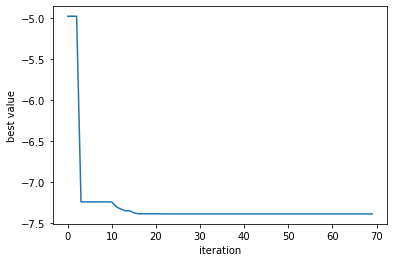

In [7]:
# Change the parameters
w = 0.8
c1 = 0.25
c2 = 0.25
iterations = 70
pop_size =100


weights, particles_record, best_global_values = particleSwarm(
    iterations=iterations, pop_size=pop_size, w=w, c1=c1, c2=c2)
positions, velocities = record_to_pv(particles_record)
plot_particles(positions=positions, velocities=velocities, normalize_velocity=True, alphas=weights,
               progresses=best_global_values, name='PSO visualization', additonal_info=f"c1={c1}, c2={c2}")

The c1 and c2 parameters essentially bias/shift the particles to favor different spaces/positionings. By increasing both of these values, there is likely to be an earlier convergence whereas decreasing these values can lead to a slower convergence and risk achieving only the local maxima. Thus, these values are critical in allowing for proper particle space exploration to find the true best position/value by optimizing convergence to properly assess particle AND global best position without local maxima or limited values due to improper balance and convergence.

# Firefly Algorithm 

The firefly algorithm (FA) was first developed in late 2007. FA was based on the flashing patterns and behavior of fireflies. The flashing light is to attract mating partners and to attract potential prey, and possibly other functions scientists are still debating. 

Now we can idealize some of the flashing characteristics of fireflies so as to develop firefly-inspired algorithms. For simplicity in describing the standard FA, we now use the following three idealized rules:

1. All fireflies are unisex, so one firefly will be attracted to other fireflies regardless of their sex. 
2. Attractiveness is proportional to a firefly's brightness. Thus for any two flashing fireflies, the less bright one will move towards the brighter one. The attractiveness is proportional to the brightness, both of which decrease as their distance increases. If there is no brighter one than a particular firefly, it will move randomly. 
3. The brightness of a firefly is affected or determined by the distance between the itself and the other firefly. 

The pseudocode of FA is below: (In our case, since we are minimizing the function, the lower the fitness the better.)

```
Data: Objective function f(x)

Result: Best or optimal solution

Intialization of parameters (pop_size,alpha,beta,gamma)
Generate an initial population of n fireflies x_i (i =1,2,.. pop_size)

while t < iterations do:
    for i = 1: pop_size (all fireflies) do
        for j = 1 :pop_Size (all fireflies) do
            if (firefly i fitness > firefly j fitness) then 
                Move firefly i towards j  using the position update equation
        end
    end
    
    rank the fireflies and find the current global best
    move the firefly with the lowest fitness randomly
    update alpha ( alpha = 0.98 * alpha)
```
The position update equation for the fireflies:

$$ x_{i}^{t+1} = x_{i}^{t} + \beta_{0}e^{-\gamma r_{ij}^{2}}(x_{j}^{t}-x_{i}^{t})+ \alpha \epsilon_{i}^{t}$$
, where $\epsilon$ is a vector of random numbers drawn from a Gaussian distribution centered around 0 with a standard deviation of 1.

$r_{ij}$ is the distance between fly i and fly j. We can use any distance function for distance r. In this assignment, we will be using the Euclidean distance.

$$ r_{ij} = \sqrt{\sum_{k=1}^{d} (x_{i,k}-x_{j,k})^{2}} $$

$\beta_{0} $ is the brightness at distance = 0. It is common to set it equal to 1. 


Now, let's setup the FA. It is similar to the setup of the PSO. 

## 2.1 (5 points)

**To-do**

1. Implement the `update_position` method. 


In [8]:
class Firefly:
    def __init__(self, position):
        """
        position: the position of this firefly. 

        """
        self.position = position
    
    def fitness(self):
        """
        This fitness function is defined as the value of this Particle
        when plugged into the function polynomial.
        """
        return -func(self.position)

    def update_position(self, firefly, alpha,  beta, gamma):
        """
        Updates the fly's position
        """        
        #YOUR CODE HERE
        distance = np.linalg.norm(self.position - firefly.position)

        # Generate random numbers from a Gaussian distribution
        epsilon = np.random.normal(loc=0, scale=1, size=len(self.position))

        # Update the position of this firefly
        self.position = self.position + (beta * np.exp(-gamma * distance**2)) * (firefly.position - self.position) + alpha * epsilon
 

## 2.2 (5 points)
**To-do**:

Follow the pseudocode and complete the `run` method.

In [9]:
class FF_Simulation:
    def __init__(self, initialFlies, alpha, beta, gamma):
        """
        initialPop: list of pop_size Particles
        w, c1, c2: constants
        best_position_global: the best position found by any Particle so far
        best_value_global: the best value found by any Particle so far 
        """
        self.flies = initialFlies
        self.pop_size = len(initialFlies)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

            
    def run(self, iterations):
        best_global_values = [] # Store the global best(smallest) value of the function to minimize in every iteration
        flies_position = []     # Stores the position of each firefly in each iteration 
        alphas = []             # Stores the alpha values of every iteration 
        for _ in range(iterations):
            # Rank the flies by fitness. 
            # BEGIN YOUR CODE
            self.flies = sorted(self.flies, key=lambda fly: fly.fitness())
            # END YOUR CODE

            # Update flies position
            # If the fly is not currently the best, update its position according to the formula
            # Otherwise random movement if the fly is currently the best. 
            # BEGIN YOUR CODE
            for i in range(self.pop_size):
                fly = self.flies[i]
                if i != self.pop_size - 1:
                    best_fly = self.flies[-1]
                    fly.update_position(best_fly, self.alpha, self.beta, self.gamma)
                else:
                    random_movement = np.random.normal(loc=0, scale=1, size=len(fly.position))
                    fly.position = fly.position + random_movement
            # END YOUR CODE
            
            # Resort the flies by fitness after update
            # BEGIN YOUR CODE
            self.flies = sorted(self.flies, key=lambda fly: fly.fitness())
            # END YOUR CODE
            
            # Update the positions for plotting.
            positions = []
            for fly in self.flies:
                positions.append(fly.position)
            flies_position.append(np.array(positions))

            # Update alpha
            alphas.append(self.alpha)
            self.alpha = 0.98*self.alpha
            
            # Update the best value
            best_global_values.append(func(self.flies[-1].position))
  
        return best_global_values, flies_position,alphas

## Create our initial population
Firefly generator. 
We now can make our initial population. You can reuse the code you wrote for the PSO functions. 

## 2.3 (2 points)

**To-do**

1. Complete `randomFlies`.

In [10]:
def randomFlies():
    # range of position: [-10, 10]
    # YOUR CODE HERE
    position = np.random.uniform(low=-10, high=10, size=2)
    return Firefly(position)

def initialSwarm(pop_size):
    """
    Create inital population of a given size.
    Returns a list of random flies.
    """
    pop = []
    for i in range(pop_size):
        temp = randomFlies()
        pop.append(temp)
    
    return pop

In [11]:
def fireFly(iterations, pop_size, alpha, beta, gamma):

    start = datetime.now()

    pop=initialSwarm(pop_size)
    best_global_values, positions, alphas =  FF_Simulation(pop,alpha,beta, gamma).run(iterations)
    
    print(f'initial best value:{best_global_values[0]}')
    print(f'final best value:{best_global_values[-1]}')
  
    plt.plot(best_global_values)
    plt.xlabel('iteration')
    plt.ylabel('best value')

    end = datetime.now()
    print("Time Elapsed for Particle Swarm: " + str(end - start))
    return best_global_values, positions, alphas

## 2.4 (7 points)

**To-do**

1. Run `fireFly`. ( 1 point)
We recommand the following setting: 

`iterations` = 100

`pop_size` = 200

`alpha` > 0.4

`beta` = 1

`gamma` > 2


2. `plot_particles` will generate two .gif visualizations and they will be saved in the folder where this notebook is located. Experiment with different combinations of parameters to see how the visulizations change. 
3. How do the parameters affect the particles convergence?( 3 points)
4. Discuss the similarities and differences between PSO and Firefly algorithm. How is PSO better than the Firefly, or vice versa. (3 points) 

initial best value:-5.61257007592568
final best value:9.278726944807516
Time Elapsed for Particle Swarm: 0:00:00.641822


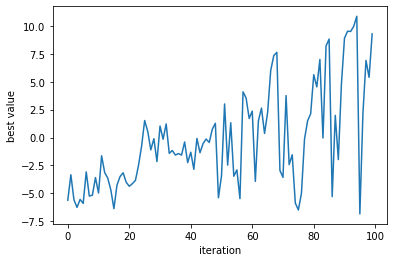

In [12]:
# Change the parameters.
iterations = 100
pop_size = 200
alpha = 0.5
beta = 1
gamma = 3
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")


Out of the parameters: alpha, beta, and gamma, similarly to PSO, if any of these values are too high or low, especially in correspondence to each other, there can be issues of premature convergence or poor levels of convergence. Alpha provides random movement which can assist in a better convergence globally rather than local maxima, beta affects attraction between the fireflies which can promote convergence, and gamma scales this attractiveness or convergence with distance.

Both algorithms are inspired by biological patterns of movement that utilize populations of points (particles/fireflies) to try and find the global optimum through space-search movement and influences (and subsequently both utilize vector movement). However, they differ in that PSO search is affected by the particle's best positioning in relation to one another as a whole whereas FF is based on the "brightness" or greater ideal of certain fireflies present. They also utilize different parameters with PSO having fewer present.

Based on the general aspects of both algorithms and this assignment, PSO appeared to be much faster at converging and finding results than FF and was simpler to adjust its parameters to find and alter the outcome. However based on the output plots, FF was able to find more maxima and minima in terms of best value across iterations that could be more useful at assessing proper convergence and the true global best value.